# **KNN (K-Nearest Neighbors)**

## Metode K-Nearest Neighbors (KNN) dalam deteksi outlier

K-Nearest Neighbors (KNN) adalah algoritma berbasis jarak yang sering digunakan dalam klasifikasi, regresi, dan deteksi outlier. Dalam deteksi outlier, KNN mengukur kedekatan suatu titik data dengan tetangga terdekatnya. Jika suatu titik data memiliki jarak yang jauh dari sebagian besar titik lain, maka dapat dianggap sebagai outlier.

Metode K-Nearest Neighbors (KNN) dalam deteksi outlier bekerja dengan mengukur jarak antara setiap titik data dengan k tetangga terdekatnya, titik data yang memiliki jarak rata-rata yang signifikan lebih besar dibandingkan dengan mayoritas titik data lainnya diidentifikasi sebagai outlier. Pemilihan nilai k sangat krusial karena memengaruhi sensitivitas metode ini, di mana nilai k yang terlalu kecil dapat melewatkan outlier dan nilai yang terlalu besar dapat salah mengklasifikasikan kluster kecil sebagai outlier.


metode untuk mengukur jarak lurus (garis terpendek) antara dua titik dalam ruang Euclidean. Jarak Euclidean diberikan oleh rumus:

$d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

Konsep ini dapat diperluas ke dimensi yang lebih tinggi dengan menjumlahkan selisih kuadrat setiap koordinat sebelum diakarkan. Euclidean Distance sering digunakan dalam algoritma clustering, k-nearest neighbors (KNN) dll

# Berikut ini contoh nya:

In [1]:
%pip install pymysql
%pip install psycopg2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.2 MB/s eta 0:00:00


 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa          55.4         65.2           5.1          3.5     64.495736         True
  2     Iris-setosa          14.0          2.0          40.9         30.0     27.237474        False
  3     Iris-setosa           3.6          1.5           4.7          3.2      1.081665        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.264575        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.244949        False
  6     Iris-setosa           1.7          0.4           6.5          1.3      2.379075        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.331662        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.223607        False
  9     Iris-setosa           4.7          3.2           4.4          2.9      1.428286    

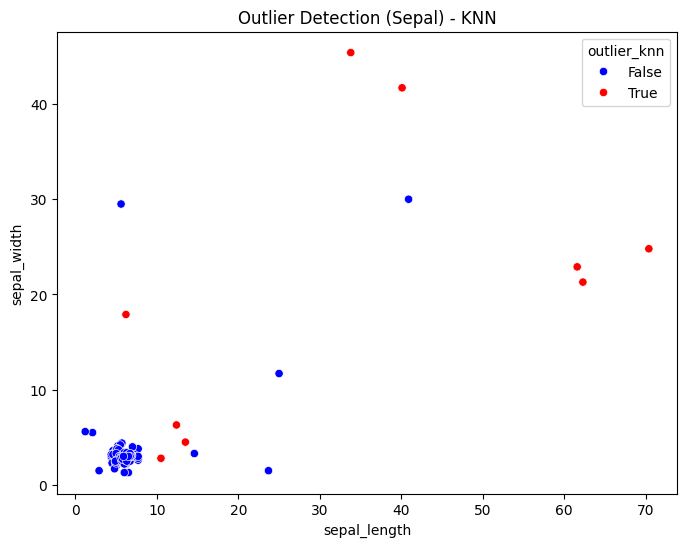

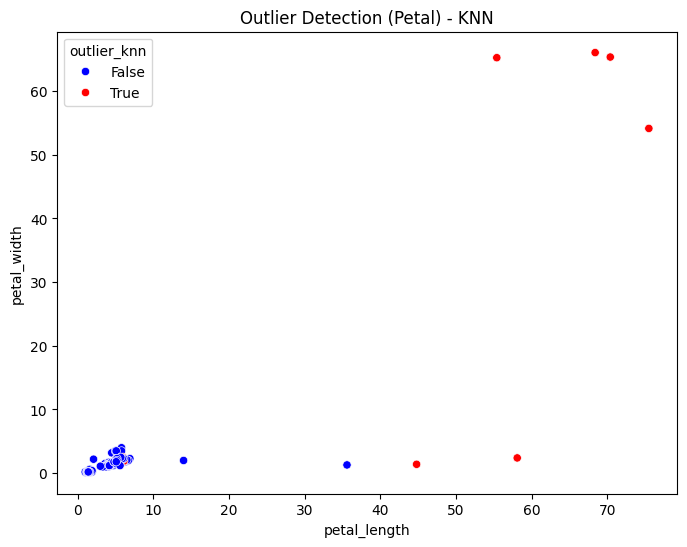

In [2]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-e0bfcfb-syauqifuady76-9d72.k.aivencloud.com",
        user="avnadmin",
        password="AVNS_bnzkAQjTkJGyBzi_GB2",
        database="defaultdb",
        port=23675
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM mad")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-1b41a3bb-ahmadsyauqifuady33-3378.f.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Cfznxfa1-nPQJ9qmWT",
        database="defaultdb",
        port=10733
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM ayam")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Cetak hasil
df_result = df_merged[["id", "class", "petal_length", "petal_width", "sepal_length", "sepal_width", "knn_distance", "outlier_knn"]]
print(df_result.to_string(index=False))
num_outliers = df_merged["outlier_knn"].sum()
print(f"\nJumlah outlier: {num_outliers}")

# Cetak data outlier
outliers = df_merged[df_merged["outlier_knn"]]
print("\nData Outlier:")
print(outliers.to_string(index=False))

# Visualisasi outlier berdasarkan K-NN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["sepal_length"], y=df_merged["sepal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Sepal) - KNN")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["petal_length"], y=df_merged["petal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Petal) - KNN")
plt.show()